In [15]:
from matplotlib import colors, pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder
from statsmodels import api
import numpy
import os
import pandas
import seaborn

pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
# pandas.set_option('display.max_colwidth', 10)

In [4]:
data_directory = os.getcwd() + '/data/'

hp_data_raw = pandas.read_csv(data_directory+'high_popularity_spotify_data.csv')
lp_data_raw = pandas.read_csv(data_directory+'low_popularity_spotify_data.csv')

hp_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   energy                    1686 non-null   float64
 1   tempo                     1686 non-null   float64
 2   danceability              1686 non-null   float64
 3   playlist_genre            1686 non-null   object 
 4   loudness                  1686 non-null   float64
 5   liveness                  1686 non-null   float64
 6   valence                   1686 non-null   float64
 7   track_artist              1686 non-null   object 
 8   time_signature            1686 non-null   int64  
 9   speechiness               1686 non-null   float64
 10  track_popularity          1686 non-null   int64  
 11  track_href                1686 non-null   object 
 12  uri                       1686 non-null   object 
 13  track_album_name          1685 non-null   object 
 14  playlist

In [5]:
lp_genre_grouped = lp_data_raw.groupby([
    'playlist_genre',
    'playlist_subgenre',
]).agg(
    count_tracks = pandas.NamedAgg(column='track_id', aggfunc='count'),
    mean_energy = pandas.NamedAgg(column='energy', aggfunc='mean'),
    mean_danceability = pandas.NamedAgg(column='danceability', aggfunc='mean'),
    mean_speechiness = pandas.NamedAgg(column='speechiness', aggfunc='mean'),
    mean_tempo = pandas.NamedAgg(column='tempo', aggfunc='mean'),
).sort_values(by='count_tracks', ascending=False)

lp_genre_grouped

,,count_tracks,mean_energy,mean_danceability,mean_speechiness,mean_tempo
playlist_genre,playlist_subgenre,,,,,
ambient,meditative,213,0.648850,0.697531,0.188229,110.200023
lofi,chill,197,0.243705,0.662235,0.096022,108.044556
arabic,modern,154,0.653182,0.693500,0.157525,114.599091
pop,scandi,133,0.692023,0.620940,0.063095,120.823083
electronic,french,116,0.576422,0.667276,0.111792,119.057129
world,jewish,101,0.745921,0.637911,0.061258,119.444851
lofi,hip-hop,100,0.392506,0.664370,0.072031,117.899560
jazz,modern,87,0.389287,0.687069,0.125729,101.995563
latin,chill,84,0.499060,0.682345,0.134732,128.249167


In [6]:
lp_electronic_modern_set = lp_data_raw[
    (lp_data_raw['playlist_genre'] == 'electronic') 
    & (lp_data_raw['playlist_subgenre'] == 'deep house')
][[
    'track_id',
    'track_name',
    'track_artist',
    'energy',
    'danceability',
    'speechiness',
    'tempo',
]]

lp_electronic_modern_set.head(5)

,track_id,track_name,track_artist,energy,danceability,speechiness,tempo
1277,3i9QKRl5Ql3pgUfNdYBVTc,glow,"Fred again.., Duskus, Four Tet, Joy Anonymous,...",0.903,0.650,0.0436,129.043
1278,3OWoUTFewCAnGIkFHdL6KK,the things that bring me joy,Luca,0.460,0.769,0.3450,126.026
1279,3rtPfogqDQQB392GBadZ3C,Palermo,"Above & Beyond, PROFF",0.900,0.605,0.0431,125.007
1280,7LMsAia3rSvaNrHjgfuJzB,Into The Night,Tonic Walter,0.781,0.790,0.0638,121.002
1281,24IEGudSMPFjk1U7klc4zp,Saturday Morning,Rules,0.615,0.800,0.0381,123.016


In [7]:
lp_data_raw['popular_flag'] = 0
hp_data_raw['popular_flag'] = 1
data = pandas.concat([lp_data_raw, hp_data_raw])
data.describe()

,time_signature,track_popularity,speechiness,danceability,duration_ms,energy,mode,instrumentalness,valence,key,tempo,loudness,acousticness,liveness,popular_flag
count,4830.000000,4831.000000,4830.000000,4830.000000,4.830000e+03,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4830.000000,4831.000000
mean,3.936646,54.761126,0.101738,0.622311,2.061508e+05,0.586691,0.562112,0.201053,0.481930,5.233333,118.269293,-9.281627,0.341217,0.167613,0.348996
std,0.409712,19.828573,0.101032,0.187706,8.174556e+04,0.246263,0.496178,0.351918,0.258036,3.580857,28.512615,7.129396,0.325382,0.124429,0.476702
min,1.000000,11.000000,0.021900,0.058900,3.537500e+04,0.000202,0.000000,0.000000,0.029600,0.000000,48.232000,-48.069000,0.000004,0.021000,0.000000
25%,4.000000,41.000000,0.038600,0.525000,1.590000e+05,0.442250,0.000000,0.000000,0.275000,2.000000,96.063000,-10.297750,0.052925,0.095400,0.000000
50%,4.000000,56.000000,0.056100,0.653000,1.948665e+05,0.633000,1.000000,0.000091,0.483000,5.000000,118.059500,-7.191000,0.224500,0.118000,0.000000
75%,4.000000,72.000000,0.118000,0.758000,2.334780e+05,0.777000,1.000000,0.200500,0.690000,8.000000,136.723500,-5.336750,0.590000,0.195000,1.000000
max,5.000000,100.000000,0.927000,0.979000,1.355260e+06,0.998000,1.000000,0.991000,0.987000,11.000000,241.426000,1.318000,0.996000,0.979000,1.000000


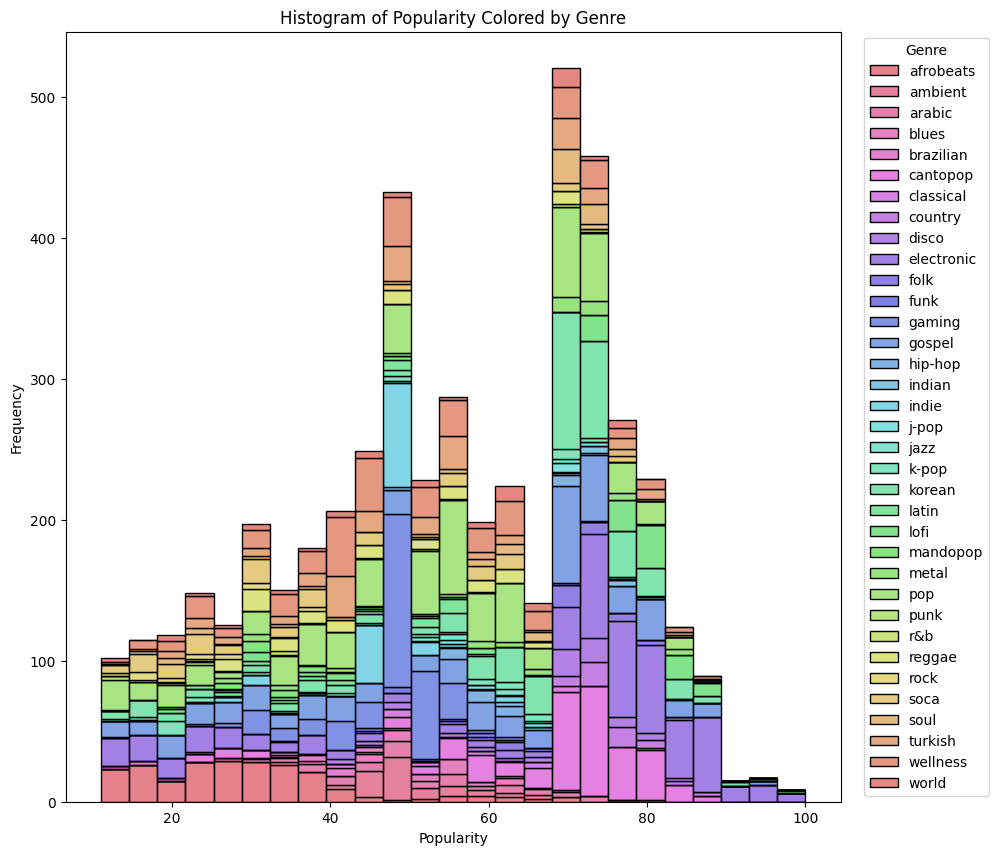

In [8]:
pyplot.figure(figsize=(10, 10)) 
genre_list = numpy.unique(data['playlist_genre'])
seaborn.histplot(
    data=data, 
    x='track_popularity', 
    hue='playlist_genre', 
    hue_order=genre_list,
    multiple="stack", 
    palette="hls"
)
pyplot.title('Histogram of Popularity Colored by Genre')
pyplot.xlabel('Popularity')
pyplot.ylabel('Frequency')
pyplot.legend(genre_list, title='Genre', loc=5, bbox_to_anchor=(1.2, 0.5))
pyplot.show()

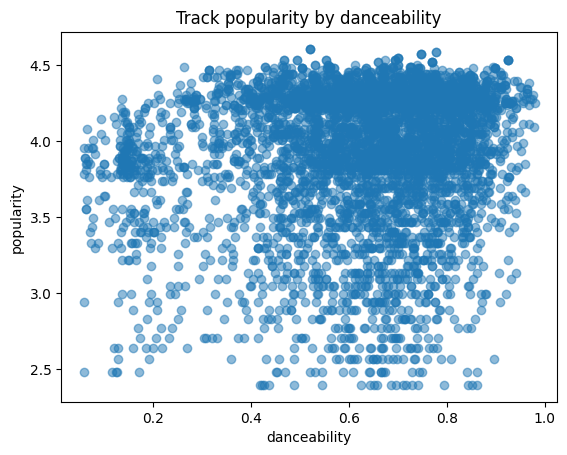

In [9]:
x = data['danceability']
y = numpy.log(data['track_popularity'])
# colors = numpy.unique(data['playlist_genre'])
# sizes = data['tbd']
pyplot.scatter(
    x, 
    y, 
    # c=colors, 
    # s=sizes, 
    alpha=0.5,
)
pyplot.xlabel("danceability")
pyplot.ylabel("popularity")
pyplot.title("Track popularity by danceability")
pyplot.show()

In [24]:
# get the set of useful data for exploring relationships and code categorical data

useful_data = data[[
    'acousticness',
    'duration_ms',
    'track_popularity',
    #'track_name',
    'tempo',
    'danceability',
    'playlist_genre',
    'loudness',
    'liveness',
    'valence',
    'time_signature',
    'speechiness',
    'track_artist',
    'instrumentalness',
    'mode',
    'key',
    'playlist_subgenre',
]].reset_index(drop=True)
categorical_features = ['playlist_genre', 'time_signature', 'track_artist', 'mode', 'key', 'playlist_subgenre']
ohe = OneHotEncoder(handle_unknown='ignore')  # 'ignore' to handle unseen categories
ohe.fit(useful_data[categorical_features])
encoded_features = ohe.transform(useful_data[categorical_features]).toarray()
encoded_feature_names = ohe.get_feature_names_out(categorical_features)
encoded_df = pandas.DataFrame(encoded_features, columns=encoded_feature_names)
forest_data = pandas.concat([useful_data.drop(categorical_features, axis=1), encoded_df], axis=1)

In [28]:
# find impactful predictors of popularity

x = forest_data.drop("track_popularity", axis=1)
y = forest_data['track_popularity']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
feature_importances = model.feature_importances_
tuples = sorted(zip(x.columns, feature_importances), key=lambda x: x[1], reverse=True)
for feature, importance in tuples:
    print(f"{feature}: {importance}")

playlist_genre_world: 0.07987757964017461
playlist_genre_pop: 0.07562330218871574
instrumentalness: 0.07331055589466287
playlist_subgenre_scandi: 0.07254730037117227
loudness: 0.06530756506941025
duration_ms: 0.04067107453277242
acousticness: 0.03344817722104338
speechiness: 0.02762427347851012
danceability: 0.027254634543459555
valence: 0.027229351121530344
tempo: 0.023703926646935734
liveness: 0.02205697429105714
playlist_subgenre_nordic: 0.021735646312944557
playlist_genre_gaming: 0.020413425481467202
playlist_subgenre_forró: 0.01655529414921789
playlist_genre_rock: 0.014419579724805301
playlist_subgenre_meditative: 0.013515995745408104
playlist_genre_cantopop: 0.013057171343961883
playlist_genre_brazilian: 0.01150058433556172
playlist_subgenre_grime: 0.010649803072651376
playlist_genre_hip-hop: 0.009858007688089353
playlist_subgenre_modern: 0.008770580433323441
playlist_genre_arabic: 0.008684417449241697
playlist_subgenre_chill: 0.0077513183726493585
playlist_subgenre_throat singin

In [32]:
model_data = forest_data[
    (forest_data['track_popularity'].notna())
    & (forest_data['playlist_genre_pop'].notna())
    & (forest_data['playlist_genre_world'].notna())
    & (forest_data['instrumentalness'].notna())
    & (forest_data['loudness'].notna())
    # & (forest_data['duration_ms'].notna())
]
# model_data['energy_null_flag'] = 0
# model_data.loc[data['energy'].isna(), 'energy_null_flag'] = 1
# model_data.loc[data['energy'].isna(), 'energy'] = 0
# model_data['danceability_null_flag'] = 0
# model_data.loc[data['danceability'].isna(), 'danceability_null_flag'] = 1
# model_data.loc[data['danceability'].isna(), 'danceability'] = 0
# model_data['log_energy'] = numpy.log(model_data['energy'])
# model_data['log_danceability'] = numpy.log(model_data['danceability'])

y = model_data['track_popularity']
x = model_data[[
    'instrumentalness',
    'playlist_genre_pop',
    'playlist_genre_world',
    'loudness',
    # 'duration_ms',
]]

model = api.OLS(y, api.add_constant(x))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     236.5
Date:                Thu, 03 Apr 2025   Prob (F-statistic):          1.04e-185
Time:                        11:31:08   Log-Likelihood:                -20849.
No. Observations:                4830   AIC:                         4.171e+04
Df Residuals:                    4825   BIC:                         4.174e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   59.3761 